In [1]:
#!wandb login --relogin

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##**EDA and configure the enviroment**

In [3]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!mkdir -p ~/.kaggle 

!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/ 

!chmod 600 ~/.kaggle/kaggle.json

In [5]:
import kaggle

In [6]:
#!kaggle competitions download -c siim-covid19-detection

In [7]:
#!unzip /content/drive/MyDrive/kaggle/siim-covid19-detection/siim-covid19-detection.zip -d /content/drive/MyDrive/kaggle/siim-covid19-detection

In [8]:
#rm -rf train

In [9]:
!pip install wandb
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 15.4 MB/s 
     |████████████████████████████████| 181 kB 95.7 MB/s 
     |████████████████████████████████| 157 kB 83.4 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 157 kB 91.1 MB/s 
     |████████████████████████████████| 157 kB 86.7 MB/s 
     |████████████████████████████████| 157 kB 91.1 MB/s 
     |████████████████████████████████| 157 kB 86.8 MB/s 
     |████████████████████████████████| 156 kB 94.1 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=ed441bed5a0a27484f695ae29c1f5c05cbe6dfb06564d358987cb7d581c52a66
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public

In [10]:
# Libraries·    
import os
import re
import wandb
import tqdm
import warnings
import glob
import ast
import cv2
import math
import pandas as pd
import numpy as np
from IPython.display import display_html
import seaborn as sns
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from sklearn.cluster import KMeans
from skimage import morphology, measure

In [11]:
# Environment check
warnings.filterwarnings("ignore")
os.environ["WANDB_SILENT"] = "true"
CONFIG = {'competition': 'siim-fisabio-rsna', '_wandb_kernel': 'aot'}

In [12]:
# Install w&b
!pip install -q --upgrade wandb
import wandb

# Login the w&b by using the wandb_api
wandb_api = "8062923cb64a71d9b2dff42537c5d3cc4b30c12b"

wandb.login(key=wandb_api)# have a login check

True

In [13]:
def show_values_on_bars(axs, h_v="v", space=0.2):
    # Plots the value at the end of the a seaborn barplot.
    # axs: the ax of the plot
    # h_v: weather or not the barplot is vertical/ horizontal
    
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(round(_x, 5), round(_y, 5), format(round(value, 5), ','), ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, format(value, ','), ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [14]:
def offset_png(x, y, path, ax, zoom, offset, border=2):
    # For adding other .png images to the graph.
    # refer from the source: https://stackoverflow.com/questions/61971090/how-can-i-add-images-to-bars-in-axes-matplotlib
    
    img = plt.imread(path)
    im = OffsetImage(img, zoom=zoom)
    im.image.axes = ax
    x_offset = offset
    ab = AnnotationBbox(im, (x, y), xybox=(x_offset, 0), frameon=False, xycoords='data', boxcoords="offset points", pad=0)
    ax.add_artist(ab)

In [15]:
def get_image_metadata(study_id, df):
    #Returns the label and bounding boxes for a specific study_id.
    
    data = df[df["study_id"] == study_id]
    
    if data["Negative for Pneumonia"].values == 1:
        label = "negative_for_pneumonia"
    elif data["Typical Appearance"].values == 1:
        label = "typical"
    elif data["Indeterminate Appearance"].values == 1:
        label = "indeterminate"
    else:
        label = "atypical"
        
    bbox = list(data["boxes"].values)
    
    return label, bbox

In [16]:
def save_dataset_artifact(run_name, artifact_name, path):
    '''Saves dataset to W&B Artifactory.
    run_name: name of the experiment
    artifact_name: under what name should the dataset be stored
    path: path to the dataset'''
    
    run = wandb.init(project='siim-covid19', 
                     name=run_name, 
                     config=CONFIG, anonymous="allow")
    artifact = wandb.Artifact(name=artifact_name, 
                              type='dataset')
    artifact.add_file(path)

    wandb.log_artifact(artifact)
    wandb.finish()
    print("Artifact has been saved successfully.")

In [17]:
def create_wandb_plot(x_data=None, y_data=None, x_name=None, y_name=None, title=None, log=None, plot="line"):
    # Create and save lineplot/barplot in W&B Environment.
    # x_data & y_data: Pandas Series containing x & y data
    # x_name & y_name: strings containing axis names
    # title: title of the graph
    # log: string containing name of log
    
    data = [[label, val] for (label, val) in zip(x_data, y_data)]
    table = wandb.Table(data=data, columns = [x_name, y_name])
    
    if plot == "line":
        wandb.log({log : wandb.plot.line(table, x_name, y_name, title=title)})
    elif plot == "bar":
        wandb.log({log : wandb.plot.bar(table, x_name, y_name, title=title)})
    elif plot == "scatter":
        wandb.log({log : wandb.plot.scatter(table, x_name, y_name, title=title)})

In [18]:
def create_wandb_hist(x_data=None, x_name=None, title=None, log=None):
    '''Create and save histogram in W&B Environment.
    x_data: Pandas Series containing x values
    x_name: strings containing axis name
    title: title of the graph
    log: string containing name of log'''
    
    data = [[x] for x in x_data]
    table = wandb.Table(data=data, columns=[x_name])
    wandb.log({log : wandb.plot.histogram(table, x_name, title=title)})

In [19]:
def return_coords(box):
    '''Returns coordinates from a bbox'''
    # Get the list of dictionaries
    box = ast.literal_eval(box)[0]
    # Get the exact x and y coordinates
    x1, y1, x2, y2 = box["x"], box["y"], box["x"] + box["width"], box["y"] + box["height"]
    # Save coordinates
    return (int(x1), int(y1), int(x2), int(y2))

In [20]:
def fix_inverted_radiograms(data, img):
    '''Fixes inverted radiograms - with PhotometricInterpretation == "MONOCHROME1"
    data: the .dcm dataset
    img: the .dcm pixel_array'''
    
    if data.PhotometricInterpretation == "MONOCHROME1":
        img = np.amax(img) - img
    
    img = img - np.min(img)
    img = img / np.max(img)
    img = (img * 255).astype(np.uint8)
    
    return img

In [21]:
# Save data to W&B Dashboard
save_dataset_artifact(run_name='save-train1',artifact_name='train_study_level',path="/content/drive/MyDrive/kaggle/siim-covid19-detection/train_image_level.csv")

save_dataset_artifact(run_name='save-train2',artifact_name='train_image_level',path="/content/drive/MyDrive/kaggle/siim-covid19-detection/train_study_level.csv")

Artifact has been saved successfully.
Artifact has been saved successfully.


In [22]:
# Read in metadata
train_image = pd.read_csv("/content/drive/MyDrive/kaggle/siim-covid19-detection/train_image_level.csv")
train_study = pd.read_csv("/content/drive/MyDrive/kaggle/siim-covid19-detection/train_study_level.csv")

In [23]:
df1_styler = train_study.head(3).style.set_table_attributes("style='display:inline'").\
                                set_caption('TRAIN STUDY')
df2_styler = train_image.head(3).style.set_table_attributes("style='display:inline'").\
                                set_caption('TRAIN IMAGE')

In [24]:
display_html(df1_styler._repr_html_() + df2_styler._repr_html_(), raw=True) #Have a look with two main .csv file

TRAIN STUDY 
 
 
   
 id 
 Negative for Pneumonia 
 Typical Appearance 
 Indeterminate Appearance 
 Atypical Appearance 
 
 
 
 
 0 
 00086460a852_study 
 0 
 1 
 0 
 0 
 
 
 1 
 000c9c05fd14_study 
 0 
 0 
 0 
 1 
 
 
 2 
 00292f8c37bd_study 
 1 
 0 
 0 
 0 
 
 
 

 
 TRAIN IMAGE 
 
 
   
 id 
 boxes 
 label 
 StudyInstanceUID 
 
 
 
 
 0 
 000a312787f2_image 
 [{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}] 
 opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472 
 5776db0cec75 
 
 
 1 
 000c3a3f293f_image 
 nan 
 none 1 0 0 1 1 
 ff0879eb20ed 
 
 
 2 
 0012ff7358bc_image 
 [{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214}, {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}] 
 opacity 1 677.42216 197.97662 1545.21983 1197.75876 opacity 1 1792.69064 402.5525 2409.71798 1606.9105 
 9d514ce429a7

In [25]:
train_image.head()

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e


### **Train_study Analysis**

In [26]:
run = wandb.init(project='siim-covid19', name='metadata_eda', config=CONFIG, anonymous="allow") 
# create a run in wandb

In [27]:
print(train_study["id"].head(5))

0    00086460a852_study
1    000c9c05fd14_study
2    00292f8c37bd_study
3    005057b3f880_study
4    0051d9b12e72_study
Name: id, dtype: object


In [28]:
# Remove '_study' from id and create study_id axis
train_study["study_id"] = train_study["id"].apply(lambda x: x.split("_")[0])
print(train_study["study_id"].head(5))

0    00086460a852
1    000c9c05fd14
2    00292f8c37bd
3    005057b3f880
4    0051d9b12e72
Name: study_id, dtype: object


In [29]:
train_study.head()

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,study_id
0,00086460a852_study,0,1,0,0,00086460a852
1,000c9c05fd14_study,0,0,0,1,000c9c05fd14
2,00292f8c37bd_study,1,0,0,0,00292f8c37bd
3,005057b3f880_study,1,0,0,0,005057b3f880
4,0051d9b12e72_study,0,0,0,1,0051d9b12e72


In [30]:
# Data for plots
pneumonia = train_study["Negative for Pneumonia"]
typical = train_study["Typical Appearance"]
indeterminate = train_study["Indeterminate Appearance"]
atypical = train_study["Atypical Appearance"]

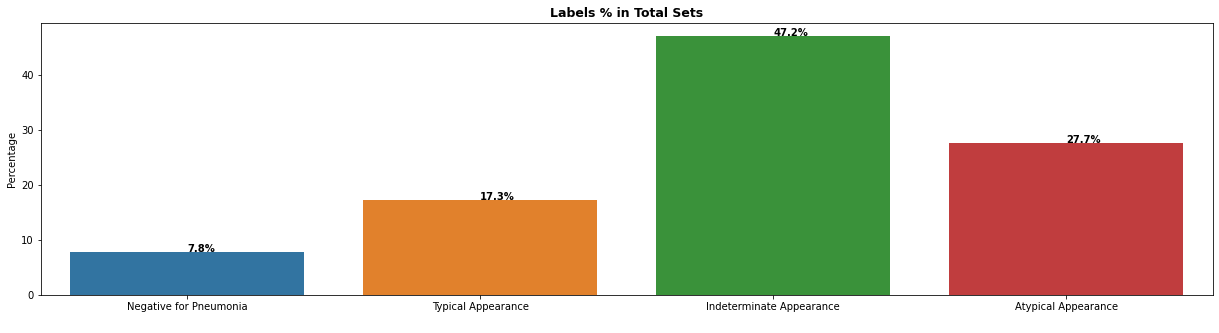

In [31]:
# Get data and transform frequencies to percentages
plt_df = train_study.groupby(['Negative for Pneumonia', 'Typical Appearance',
       'Indeterminate Appearance', 'Atypical Appearance']).count().reset_index()

plt_df["label"] = ['Negative for Pneumonia', 'Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance']
plt_df["perc"] = plt_df["id"]/plt_df["id"].sum()*100 # Calculate the percentage

# Plotting
bar,ax = plt.subplots(figsize=(21,5))
ax = sns.barplot(x=plt_df["label"], y=plt_df["perc"], ci=None, orient='v')
ax.set_title("Labels % in Total Sets", fontsize=12.5, weight = "bold")

ax.set_xlabel(" ")
ax.set_ylabel("Percentage")

for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width() / 2,rect.get_height(), "%.1f%%"% rect.get_height(), weight='bold')

In [32]:
create_wandb_plot(x_data=plt_df["label"].values,
         y_data=plt_df["perc"].values,
         x_name="Label", y_name="Percentage", 
         title="Label % in Total Sets", 
         log="perc", plot="bar")

In [33]:
wandb.finish()

### **Train_Img Analysis**

In [34]:
run = wandb.init(project='siim-covid19', name='train_imgs_eda', config=CONFIG, anonymous="allow")

In [35]:
train_image.head(3)

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7


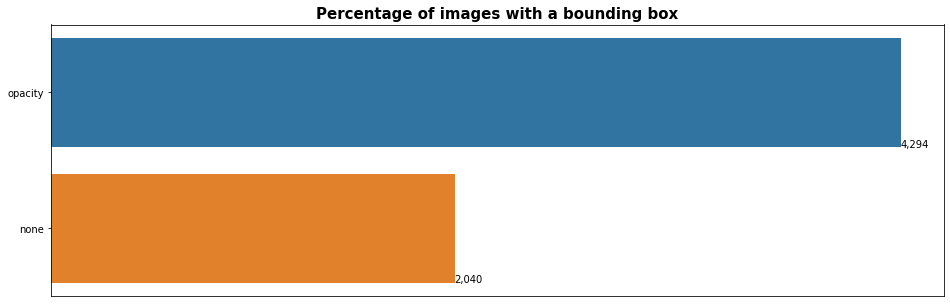

In [36]:
# Process id
train_image["image_id"] = train_image["id"].apply(lambda x: x.split("_")[0])

# Data for plotting
df = train_image["label"].apply(lambda x: x.split(" ")[0]).value_counts().reset_index()

# Plotting
plt.figure(figsize=(16, 5))
ax = sns.barplot(data=df, y="index", x="label")
show_values_on_bars(ax, h_v="h", space=0.2)
plt.title("Percentage of images with a bounding box", fontsize=15, weight='bold')
plt.xticks([])
plt.ylabel('')
plt.xlabel('');


In [37]:
create_wandb_plot(x_data=df["index"], 
         y_data=df["label"].values, 
         x_name="BoundingBox", y_name="Frequency", 
         title="Images with bbox",
         log="bbox", plot="bar")

In [38]:
# Crate df
df = train_image["StudyInstanceUID"].value_counts().reset_index().sort_values("StudyInstanceUID", ascending=False)
# print("max number of images available per study:" + df["StudyInstanceUID"].max())
# print("min number of images available per study:" + df["StudyInstanceUID"].min())

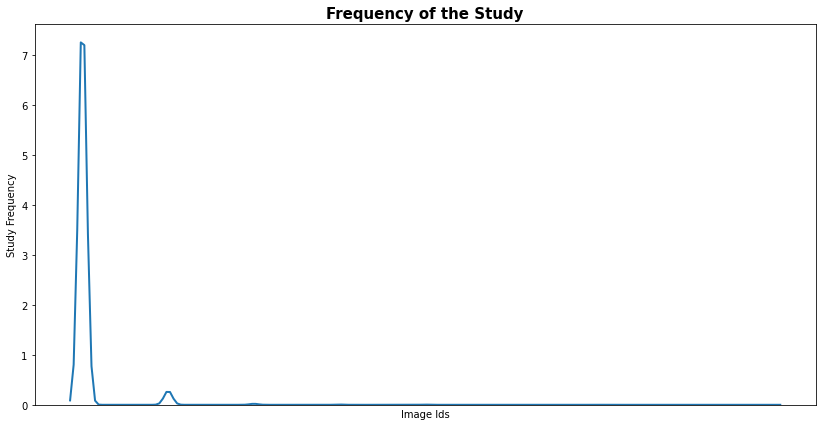

In [39]:
# Plot
plt.figure(figsize=(14, 7))
sns.distplot(a=df["StudyInstanceUID"], hist=False, kde_kws=dict(lw=2, ls="-"))
plt.title("Frequency of the Study", fontsize=15, weight='bold')
plt.xticks([])
plt.ylabel('Study Frequency')
plt.xlabel('Image Ids');

In [40]:
wandb.log({"max_images_on_study" : df["StudyInstanceUID"].max()})
create_wandb_hist(x_data=df["StudyInstanceUID"], 
         x_name="Image Freq", title="No. images per study", 
         log="hist")

In [41]:
wandb.finish()

In [42]:
# Merge all data set info together
train = pd.merge(train_image, train_study, left_on="StudyInstanceUID", right_on="study_id")

train.drop(["id_x", "StudyInstanceUID", "id_y"], axis=1, inplace=True)

In [43]:
train.head(5)

,boxes,label,image_id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,study_id
0,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,000a312787f2,0,1,0,0,5776db0cec75
1,NaN,none 1 0 0 1 1,000c3a3f293f,1,0,0,0,ff0879eb20ed
2,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,0012ff7358bc,0,1,0,0,9d514ce429a7
3,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,001398f4ff4f,0,0,0,1,28dddc8559b2
4,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,001bd15d1891,0,1,0,0,dfd9fdd85a3e


In [44]:
train[train["study_id"] == "0fd2db233deb"]

,boxes,label,image_id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,study_id
137,NaN,none 1 0 0 1 1,04cc2f7f4c4b,0,0,1,0,0fd2db233deb
138,NaN,none 1 0 0 1 1,05c063f5cef5,0,0,1,0,0fd2db233deb
139,NaN,none 1 0 0 1 1,156cb1f5c689,0,0,1,0,0fd2db233deb
140,"[{'x': 561.30269, 'y': 163.28797, 'width': 883...",opacity 1 561.30269 163.28797 1445.02377 1495....,26f643772090,0,0,1,0,0fd2db233deb
141,NaN,none 1 0 0 1 1,4c414b793562,0,0,1,0,0fd2db233deb
142,NaN,none 1 0 0 1 1,a5a364383f34,0,0,1,0,0fd2db233deb
143,NaN,none 1 0 0 1 1,b121806162c3,0,0,1,0,0fd2db233deb
144,NaN,none 1 0 0 1 1,bee62c601ae9,0,0,1,0,0fd2db233deb
145,NaN,none 1 0 0 1 1,c6e92e59a0ae,0,0,1,0,0fd2db233deb


## **More EDA**

In [45]:
# train_directory = "/content/drive/MyDrive/kaggle/siim-covid19-detection/train/"
# test_directory = "/content/drive/MyDrive/kaggle/siim-covid19-detection/test/"

# train_study['StudyInstanceUID'] = train_study['id'].apply(lambda x: x.replace('_study', ''))
# del train_study['id']
# train_df = train_image.merge(train_study, on='StudyInstanceUID')

In [46]:
# import numpy as np 
# import pandas as pd 
# from tqdm import tqdm
# import glob
# import os
# import matplotlib.pyplot as plt
# import matplotlib.pylab as pylab
# import seaborn as sns
# import pprint
# import pydicom as dicom
# from pydicom.pixel_data_handlers.util import apply_voi_lut
# import albumentations as A
# import cv2
# import wandb

# from PIL import Image
# #from colorama import Fore, Back, Style

# training_paths = []

# for sid in tqdm(train_df['StudyInstanceUID']):
#     training_paths.append(glob.glob(os.path.join(train_directory, sid +"/*/*"))[0])

# train_df['path'] = training_paths

In [47]:
# params = {'legend.fontsize': 'x-large',
#           'figure.figsize': (20, 32),
#          'axes.labelsize': 'x-large',
#          'axes.titlesize':'x-large',
#          'xtick.labelsize':'x-large',
#          'ytick.labelsize':'x-large'}
# pylab.rcParams.update(params)

# fig, ax = plt.subplots(4,2)
# sns.kdeplot(train_df["Negative for Pneumonia"], shade=True,ax=ax[0,0],color="#ffb4a2")
# ax[0,0].set_title("Negative for Pneumonia Distribution", fontsize=20,weight="bold")
# sns.countplot(x = train_df["Negative for Pneumonia"], ax=ax[0,1],color="#ffb4a2")
# ax[0,1].set_title("Negative for Pneumonia Distribution", fontsize=20,weight="bold")

# sns.kdeplot(train_df["Typical Appearance"], shade=True,ax=ax[1,0],color="#e5989b")
# ax[1,0].set_title("Typical Appearance Distribution", fontsize=20,weight="bold")
# sns.countplot(x = train_df["Typical Appearance"], ax=ax[1,1],color="#e5989b")
# ax[1,1].set_title("Typical Appearance Distribution", fontsize=20,weight="bold")

# sns.kdeplot(train_df["Indeterminate Appearance"], shade=True,ax=ax[2,0],color="#b5838d")
# ax[2,0].set_title("Indeterminate Appearance Distribution", fontsize=20,weight="bold")
# sns.countplot(x = train_df["Indeterminate Appearance"], ax=ax[2,1],color="#b5838d")
# ax[2,1].set_title("Indeterminate Appearance Distribution", fontsize=20,weight="bold")

# sns.kdeplot(train_df["Atypical Appearance"], shade=True,ax=ax[3,0],color="#6d6875")
# ax[3,0].set_title("Atypical Appearance Distribution", fontsize=20,weight="bold")
# sns.countplot(x = train_df["Atypical Appearance"], ax=ax[3,1],color="#6d6875")
# ax[3,1].set_title("Atypical Appearance Distribution", fontsize=20,weight="bold")

# fig.subplots_adjust(wspace=0.2, hspace=0.4, top=0.93)
# plt.show()


## **Show Images**

In [48]:
run = wandb.init(project='siim-covid19', name='image_explore', config=CONFIG, anonymous="allow")

In [49]:
def show_dcm_info(study_ids, df):
    #Show .dcm images along with description.
    wandb_logs = []
    
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(21,10))

    # Get paths .dcm path
    dcm_paths = [glob.glob(f"/content/drive/MyDrive/kaggle/siim-covid19-detection/train/{study_id}/*/*")[0]
                 for study_id in study_ids]
    datasets = [pydicom.dcmread(path) for path in dcm_paths]
    images = [apply_voi_lut(dataset.pixel_array, dataset) for dataset in datasets]

    # Loop through the information
    for study_id, data, img, i in zip(study_ids, datasets, images, range(2*3)):
        # Fix inverted images
        img = fix_inverted_radiograms(data, img)

        # Below function available in functions section ;)
        label, bbox = get_image_metadata(study_id, df)
        
        # Check for bounding box and add if it's the case
        try: 
            # For no bbox, the list is [nan]
            no_box = math.isnan(bbox[0])
            pass
        except TypeError:
            # Retrieve the bounding box
            all_coords = []
            for box in bbox:
                all_coords.append(return_coords(box))

            for (x1, y1, x2, y2) in all_coords:
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 80, 255), 15)
                cv2.putText(img, label, (x1, y1-14), 
                            cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 0), 4)
                
        # Plot the image
        x = i // 3 #3
        y = i % 3 #3
        
        axes[x, y].imshow(img, cmap="rainbow")
        axes[x, y].set_title(f"Label: {label} \n Sex: {data.PatientSex} | Body Part: {data.BodyPartExamined}\n Study ID: {study_id}", fontsize=14, weight='bold')
        axes[x, y].axis('off');
        
        # Save to W&B
        wandb_logs.append(wandb.Image(img, caption=f"Label: {label} \n Sex: {data.PatientSex} | Body Part: {data.BodyPartExamined}"))
          
    wandb.log({f"{label}": wandb_logs})

Typical Appearance

In [50]:
#show_dcm_info(study_ids=["72044bb44d41", "f807cd855d31", "b949689a9ef1", "612ea5194007"], df=train)

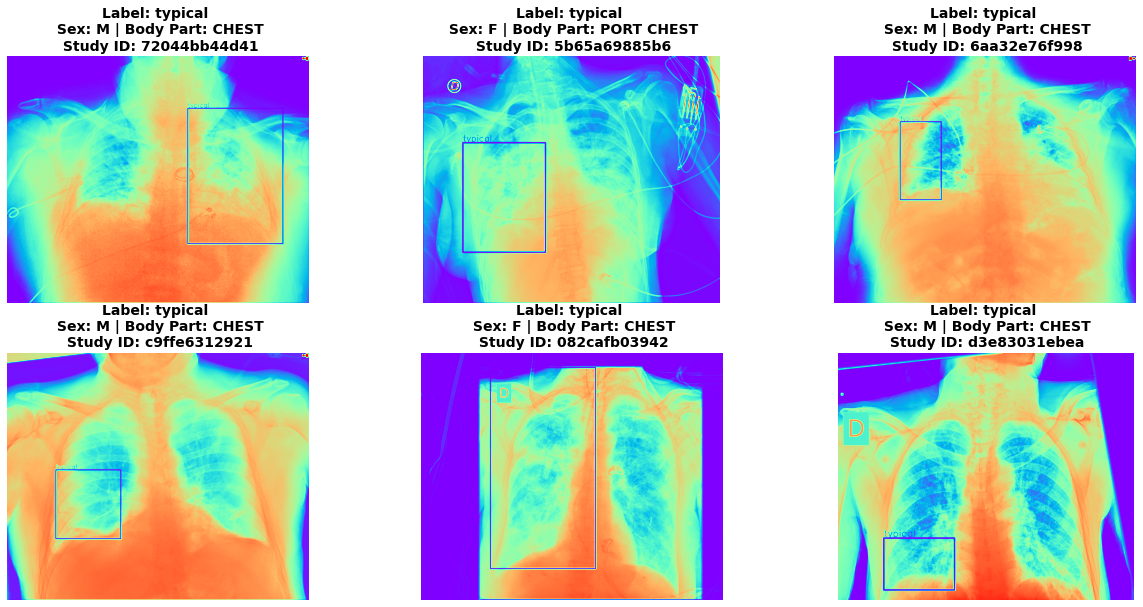

In [51]:
show_dcm_info(study_ids=["72044bb44d41", "5b65a69885b6", "6aa32e76f998","c9ffe6312921", "082cafb03942", "d3e83031ebea"], df=train)

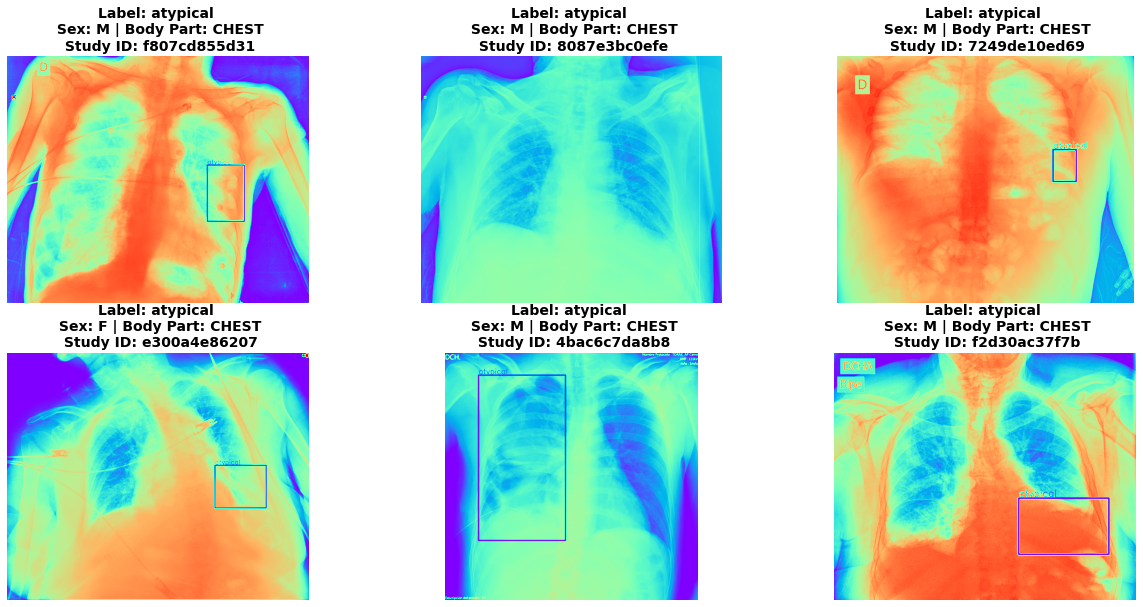

In [52]:
show_dcm_info(study_ids=["f807cd855d31", "8087e3bc0efe", "7249de10ed69","e300a4e86207", "4bac6c7da8b8", "f2d30ac37f7b"], df=train)

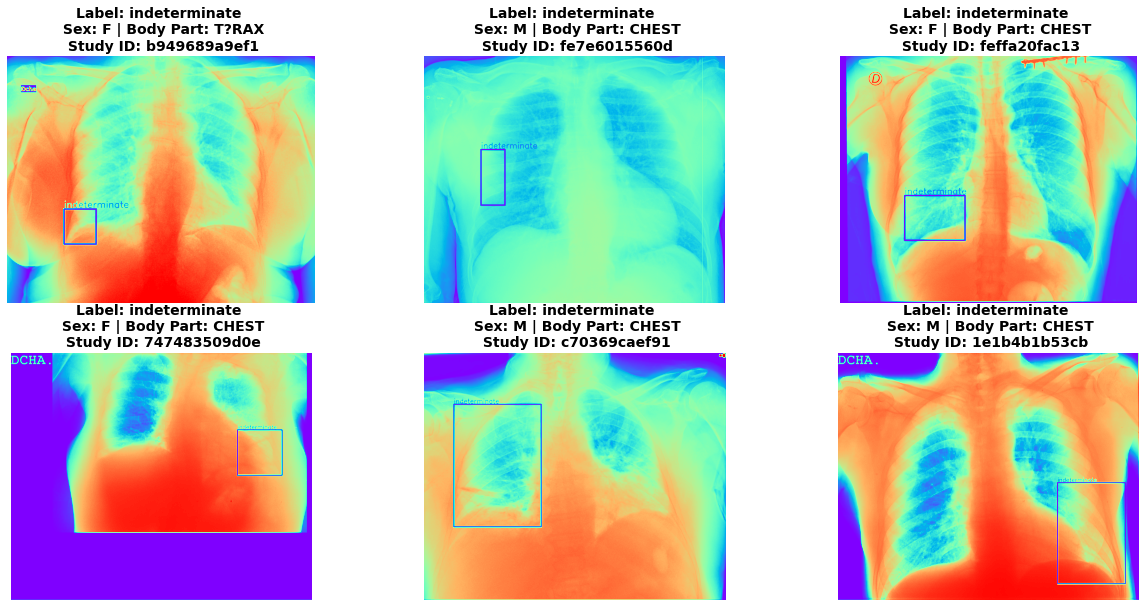

In [53]:
show_dcm_info(study_ids=["b949689a9ef1", "fe7e6015560d", "feffa20fac13","747483509d0e", "c70369caef91", "1e1b4b1b53cb"], df=train)

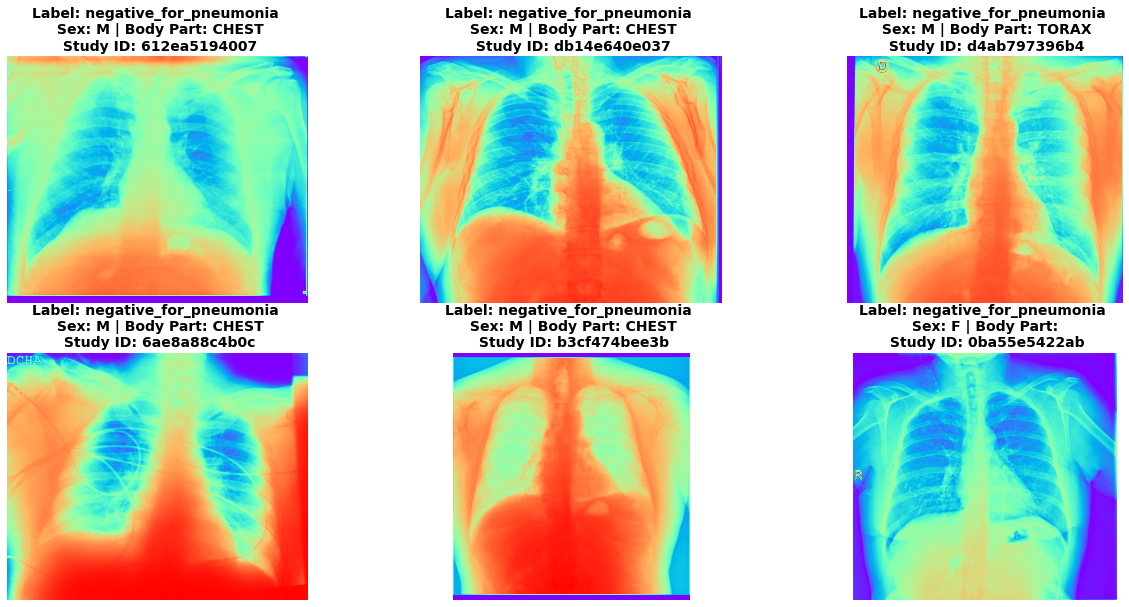

In [54]:
show_dcm_info(study_ids=["612ea5194007", "db14e640e037", "d4ab797396b4","6ae8a88c4b0c", "b3cf474bee3b", "0ba55e5422ab"], df=train)

##**Data Augmentation**

In [55]:
!pip install -q -U albumentations

In [56]:
import albumentations

#albumentations.RandomFog(p=1)

## **Extract Metadata from .dcm**

In [57]:
def get_observation_data(path):
    """Get information from the .dcm files.
    path: complete path to the .dcm file"""

    image_data = pydicom.read_file(path)
    
    # Dictionary to store the information from the image
    observation_data = {
        "FileNumber" : path.split("/")[5],
        "Rows" : image_data.get("Rows"),
        "Columns" : image_data.get("Columns"),
        "PatientID" : image_data.get("PatientID"),
        "PatientName" : image_data.get("PatientName"),
        "PhotometricInterpretation" : image_data.get("PhotometricInterpretation"),
        "StudyInstanceUID" : image_data.get("StudyInstanceUID"),
        "SamplesPerPixel" : image_data.get("SamplesPerPixel"),
        "BitsAllocated" : image_data.get("BitsAllocated"),
        "BitsStored" : image_data.get("BitsStored"),
        "HighBit" : image_data.get("HighBit"),
        "PixelRepresentation" : image_data.get("PixelRepresentation"),
    }

    # String columns
    str_columns = ["ImageType", "Modality", "PatientSex", "BodyPartExamined"]
    for k in str_columns:
        observation_data[k] = str(image_data.get(k)) if k in image_data else None

    
    return observation_data

In [58]:
p = "/content/drive/MyDrive/kaggle/siim-covid19-detection/train/00792b5c8852/1f52bcb3143e/3fadf4b48db3.dcm"
example = get_observation_data(p)
print(example)

{'FileNumber': 'siim-covid19-detection', 'Rows': 3052, 'Columns': 3052, 'PatientID': 'e398ad6e7a6a', 'PatientName': '7a65899215b6', 'PhotometricInterpretation': 'MONOCHROME2', 'StudyInstanceUID': '00792b5c8852', 'SamplesPerPixel': 1, 'BitsAllocated': 16, 'BitsStored': 12, 'HighBit': 11, 'PixelRepresentation': 0, 'ImageType': "['ORIGINAL', 'PRIMARY']", 'Modality': 'DX', 'PatientSex': 'F', 'BodyPartExamined': 'CHEST'}


In [59]:
# from sklearn.utils import resample
# file_path = p
# data0 = pydicom.dcmread(p)
# data_img = Image.fromarray(data0.pixel_array)
# data_img_rotated = data_img.rotate(angle=45,resample=Image.BICUBIC)

# fig, ax = plt.subplots(1, 2, figsize=[15, 8])
# ax[0].imshow(data0.pixel_array, cmap=plt.cm.gray)
# ax[1].imshow(data0.pixel_array, cmap=plt.cm.plasma)   
# plt.title("StudyInstanceUID: 00792b5c8852")
# plt.show()

In [60]:
## === GET ALL METADATA ===
## Get all paths to .dcm files
#all_paths = glob.glob("/content/drive/MyDrive/kaggle/siim-covid19-detection/train/*/*/*")
## === Get metadata ===
#exceptions = 0
#dicts = []
#for path in tqdm.tqdm(all_paths):
#    # Get .dcm metadata
#    ### TODO: add .dcm id
#    try:
#        d = get_observation_data(path)
#        dicts.append(d)
#    except Exception as e:
#        exceptions += 1
#        continue
#

In [61]:
## === SAVE METADATA ===
## Convert into df
#meta_train_data = pd.DataFrame(data=dicts, columns=example.keys())
##meta_train_data[""]
## Export information
#meta_train_data.to_csv("meta_train.csv", index=False)
#print("Metadata processed & saved successfuly~~~")

In [62]:
#meta_train_data.to_csv("/content/drive/MyDrive/kaggle/siim-covid19-detection/meta_train.csv", index=False)

In [63]:
meta_train_data = pd.read_csv("/content/drive/MyDrive/kaggle/siim-covid19-detection/meta_train.csv")

In [64]:
meta_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6334 entries, 0 to 6333
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   FileNumber                 6334 non-null   object
 1   Rows                       6334 non-null   int64 
 2   Columns                    6334 non-null   int64 
 3   PatientID                  6334 non-null   object
 4   PatientName                6334 non-null   object
 5   PhotometricInterpretation  6334 non-null   object
 6   StudyInstanceUID           6334 non-null   object
 7   SamplesPerPixel            6334 non-null   int64 
 8   BitsAllocated              6334 non-null   int64 
 9   BitsStored                 6334 non-null   int64 
 10  HighBit                    6334 non-null   int64 
 11  PixelRepresentation        6334 non-null   int64 
 12  ImageType                  6334 non-null   object
 13  Modality                   6334 non-null   object
 14  PatientS

In [65]:
dcm_meta = meta_train_data

dcm_meta = pd.concat([dcm_meta, train], axis=1)

dcm_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6334 entries, 0 to 6333
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   FileNumber                 6334 non-null   object
 1   Rows                       6334 non-null   int64 
 2   Columns                    6334 non-null   int64 
 3   PatientID                  6334 non-null   object
 4   PatientName                6334 non-null   object
 5   PhotometricInterpretation  6334 non-null   object
 6   StudyInstanceUID           6334 non-null   object
 7   SamplesPerPixel            6334 non-null   int64 
 8   BitsAllocated              6334 non-null   int64 
 9   BitsStored                 6334 non-null   int64 
 10  HighBit                    6334 non-null   int64 
 11  PixelRepresentation        6334 non-null   int64 
 12  ImageType                  6334 non-null   object
 13  Modality                   6334 non-null   object
 14  PatientS

In [66]:
#Show data from particular column
dcm_meta[dcm_meta["Negative for Pneumonia"].isin([0, 1])]

,FileNumber,Rows,Columns,PatientID,PatientName,PhotometricInterpretation,StudyInstanceUID,SamplesPerPixel,BitsAllocated,BitsStored,...,PatientSex,BodyPartExamined,boxes,label,image_id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,study_id
0,siim-covid19-detection,3480,4240,cc5c2ee2f7af,cc5c2ee2f7af,MONOCHROME2,fa6d3b56e333,1,8,8,...,F,CHEST,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,000a312787f2,0,1,0,0,5776db0cec75
1,siim-covid19-detection,3488,4256,f1eb548b0d4e,6110bb774cc7,MONOCHROME2,7dbc098b8eaf,1,16,12,...,F,CHEST,NaN,none 1 0 0 1 1,000c3a3f293f,1,0,0,0,ff0879eb20ed
2,siim-covid19-detection,2800,3408,f2522fc67e19,3a15d73dffa3,MONOCHROME1,20a86e21402f,1,16,15,...,M,CHEST,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,0012ff7358bc,0,1,0,0,9d514ce429a7
3,siim-covid19-detection,2901,2416,bd317c28186c,ff78a810a3b1,MONOCHROME2,b1c31c1e103a,1,16,12,...,M,CHEST,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,001398f4ff4f,0,0,0,1,28dddc8559b2
4,siim-covid19-detection,1140,1387,38294c28a745,689ce2c627cc,MONOCHROME2,e395615a9a0d,1,16,12,...,F,CHEST,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,001bd15d1891,0,1,0,0,dfd9fdd85a3e
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6329,siim-covid19-detection,3052,3020,e35ed9590570,04f993716bff,MONOCHROME1,90ebb1c07f60,1,16,12,...,F,CHEST,NaN,none 1 0 0 1 1,ffcc6edd9445,1,0,0,0,7e6c68462e06
6330,siim-covid19-detection,1140,1387,f49df2004d9a,e06001c5d746,MONOCHROME2,77b4e0d0a49d,1,16,12,...,F,CHEST,NaN,none 1 0 0 1 1,ffd91a2c4ca0,1,0,0,0,8332bdaddb6e
6331,siim-covid19-detection,4020,4891,42974169a22e,f66f49cbd706,MONOCHROME2,bf443fd8264c,1,16,12,...,F,CHEST,"[{'x': 2197.38566, 'y': 841.07361, 'width': 31...",opacity 1 2197.38566 841.07361 2513.80265 1292...,ffd9b6cf2961,0,1,0,0,7eed9af03814
6332,siim-covid19-detection,2801,2802,06a48aa199b2,0e7106461b4a,MONOCHROME2,788eb199cbc8,1,16,12,...,F,NaN,"[{'x': 2729.27083, 'y': 332.26044, 'width': 14...",opacity 1 2729.27083 332.26044 4225.52099 2936...,ffdc682f7680,0,1,0,0,a0cb0b96fb3d


## **Convert .dcm to .jpg**

In [67]:
import os

from PIL import Image
import pandas as pd
from tqdm.auto import tqdm

In [68]:
import numpy as np
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

# To implement the data processing for the .dcm file, I refer to the code answered in stackoverflow
# Link : https://stackoverflow.com/a/69540945

def read_xray(path, voi_lut = True, fix_monochrome = True):
    
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted
    # MONOCHROME1 indicates that the greyscale ranges from bright to dark with ascending pixel values
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":  
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
        
    return data

In [69]:
# Reset the size of the image
def resize(array, size, keep_ratio=True, resample=Image.LANCZOS):
    
    image = Image.fromarray(array)
    
    if keep_ratio:
        image.thumbnail((size, size), resample)
    else:
        image = image.resize((size, size), resample)
    
    return image

In [70]:
#train_image
#train_study

In [71]:
!sudo pip install pylibjpeg 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [72]:
# import os
# os.chdir("/content/drive/MyDrive/Colab Notebooks") 

In [73]:
#!bash /content/drive/MyDrive/Anaconda3-5.3.0-Linux-x86_64.sh -bfp /usr/local

In [74]:
# import sys
# sys.path.insert(0, "/usr/local/lib/python3.7/dist-packages")

In [75]:
#!conda --version

In [76]:
#!conda install -c bioconda -yq python=3.7 muscle

In [77]:
#!conda config --add channels conda-forge

In [78]:
#!conda upgrade -n base -c defaults --override-channels conda

In [79]:
#!conda install gdcm -c conda-forge

In [80]:
# !pip3 install python-gdcm

In [81]:
# !pip3 install pylibjpeg

In [82]:
# import pylibjpeg

# import gdcm

In [83]:
# rm -rf /content/drive/MyDrive/kaggle/siim-jpg/test

In [84]:
# image_id = []
# dim0 = []
# dim1 = []
# splits = []

# for split in ['test', 'train']:
#     #/content/drive/MyDrive/kaggle/siim-jpg
#     save_dir = f'/content/drive/MyDrive/kaggle/siim-jpg/{split}/'

#     os.makedirs(save_dir, exist_ok=True)
#     #/content/drive/MyDrive/kaggle/siim-covid19-detection
#     for dirname, _, filenames in tqdm(os.walk(f'../content/drive/MyDrive/kaggle/siim-covid19-detection/{split}')):
#         for file in filenames:
#             xray = read_xray(os.path.join(dirname, file))
#             im = resize(xray, size=256)  
#             im.save(os.path.join(save_dir, file.replace('dcm', 'jpg')))

#             image_id.append(file.replace('.dcm', ''))
#             dim0.append(xray.shape[0]) # length of the 1st dimension of the apply_voi_lut(dicom.pixel_array, dicom)
#             dim1.append(xray.shape[1]) # length of the 2nd dimension of the apply_voi_lut(dicom.pixel_array, dicom)
#             splits.append(split)

In [85]:
# df = pd.DataFrame.from_dict({'image_id': image_id, 'dim0': dim0, 'dim1': dim1, 'split': splits})
# df.to_csv('meta.csv', index=False)

In [86]:
# df.info()

In [ ]:
!cp -r /content/drive/MyDrive/kaggle/siim-jpg /content

In [ ]:
!cp /content/drive/MyDrive/kaggle/meta.csv /content

In [ ]:
import os
import gc
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from shutil import copyfile
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
TRAIN_PATH = '/content/siim-jpg/train/'
IMG_SIZE = 256
BATCH_SIZE = 16
EPOCHS = 10

In [ ]:
tmp_tarin_image = pd.DataFrame()

tmp_tarin_image = train_image

# Modify values in the id column
tmp_tarin_image['id'] = tmp_tarin_image.apply(lambda row: row.id.split('_')[0], axis=1)
# Add absolute path
tmp_tarin_image['path'] = tmp_tarin_image.apply(lambda row: TRAIN_PATH+row.id+'.jpg', axis=1)
# Get image level labels
tmp_tarin_image['image_level'] = tmp_tarin_image.apply(lambda row: row.label.split(' ')[0], axis=1)

tmp_tarin_image.head(5)

In [ ]:
#Load meta.csv file
meta_df = pd.read_csv('/content/meta.csv')
train_meta_df = meta_df.loc[meta_df.split == 'train']
train_meta_df = train_meta_df.drop('split', axis=1)
train_meta_df.columns = ['id', 'dim0', 'dim1']

train_meta_df.head(5)

In [ ]:
# Merge both the dataframes
merge_train_df = pd.DataFrame()
merge_train_df = tmp_tarin_image.merge(train_meta_df, on='id',how="left")
merge_train_df.head(2)

In [ ]:
# Create train and validation split.

#train_df, valid_df = train_test_split(merge_train_df, test_size=0.2, random_state=42, stratify=merge_train_df.image_level.values)

train_df, test_df = train_test_split(merge_train_df, test_size=0.1, random_state=42, stratify=merge_train_df.image_level.values)

train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df.image_level.values)

train_df.loc[:, 'split'] = 'train'
valid_df.loc[:, 'split'] = 'valid'
test_df.loc[:, 'split'] = 'test'

final_test_df = pd.DataFrame(test_df).reset_index(drop=True)
final_merge_df = pd.concat([train_df, valid_df]).reset_index(drop=True)

In [ ]:
print(f'Size of dataset: {len(merge_train_df)}, training images: {len(train_df)}. validation images: {len(valid_df)}. test images: {len(test_df)}')

In [ ]:
final_test_df.head(2)

In [ ]:
final_merge_df.head(2)

In [ ]:
os.makedirs('/content/siim-jpg/images/train', exist_ok=True)
os.makedirs('/content/siim-jpg/images/valid', exist_ok=True)

os.makedirs('/content/siim-jpg/labels/train', exist_ok=True)
os.makedirs('/content/siim-jpg/labels/valid', exist_ok=True)

os.makedirs('/content/siim-jpg/test0', exist_ok=True)

!ls /content/siim-jpg/images

!ls /content/siim-jpg

In [ ]:
# Move the images to relevant split folder.
for i in tqdm(range(len(final_merge_df))):
    row = final_merge_df.loc[i]
    if row.split == 'train':
        copyfile(row.path, f'/content/siim-jpg/images/train/{row.id}.jpg')
    else:
        copyfile(row.path, f'/content/siim-jpg/images/valid/{row.id}.jpg')


In [ ]:
for i in tqdm(range(len(final_test_df))):
  row = final_test_df.loc[i]
  copyfile(row.path, f'/content/siim-jpg/test0/{row.id}.jpg')

##**Create the .yaml file**

In [ ]:
# Download YOLOv5
!git clone https://github.com/ultralytics/yolov5 # clone repo
%cd yolov5
# Install dependencies requirements.txt 安装全部依赖
%pip install -qr requirements.txt  # install dependencies

%cd ../
#pytorch
import torch
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

In [ ]:
# Create .yaml file 
import yaml

data_yaml = dict(
    train = '/content/siim-jpg/images/train',
    val = '/content/siim-jpg/images/valid',
    nc = 2,
    names = ['none', 'opacity']
)

# Create the file in the yolov5/data/ directory.
with open('/content/yolov5/data/data.yaml', 'w') as outfile:
    yaml.dump(data_yaml, outfile, default_flow_style=True)
    
%cat /content/yolov5/data/data.yaml

## **Scale the bounding box** ##

In [ ]:
# Get the raw bounding box by parsing the row value of the label column.
def get_bbox(row):
    bboxes = []
    bbox = []
    for i, l in enumerate(row.label.split(' ')):
        if (i % 6 == 0) | (i % 6 == 1):
            continue
        bbox.append(float(l))
        if i % 6 == 5:
            bboxes.append(bbox)
            bbox = []  
            
    return bboxes

# Scale the bounding boxes according to the size of the resized image. 
def scale_bbox(row, bboxes):
    # Get the scaling factor of the bounding box size after conversion to .jpg file
    scale_x = IMG_SIZE/row.dim1
    scale_y = IMG_SIZE/row.dim0
    
    scaled_bboxes = []
    for bbox in bboxes:
        x = int(np.round(bbox[0]*scale_x, 4)) # indicate the decimal to 0.0001
        y = int(np.round(bbox[1]*scale_y, 4))
        x1 = int(np.round(bbox[2]*(scale_x), 4))
        y1 = int(np.round(bbox[3]*scale_y, 4))

        scaled_bboxes.append([x, y, x1, y1]) # xmin, ymin, xmax, ymax
        
    return scaled_bboxes

# Convert the bounding boxes in YOLO format.
def get_yolo_format_bbox(img_w, img_h, bboxes):
    yolo_boxes = []
    for bbox in bboxes:
        w = bbox[2] - bbox[0] # xmax - xmin
        h = bbox[3] - bbox[1] # ymax - ymin
        xc = bbox[0] + int(np.round(w/2)) # xmin + width/2
        yc = bbox[1] + int(np.round(h/2)) # ymin + height/2
        
        yolo_boxes.append([xc/img_w, yc/img_h, w/img_w, h/img_h]) 
        # xc:x_center yc:y_center w:width h:height
    
    return yolo_boxes

In [ ]:
final_merge_df.head(1)

In [ ]:
# Prepare the txt files for bounding box
for i in tqdm(range(len(final_merge_df))):
    row = final_merge_df.loc[i]
    # Get image id
    img_id = row.id
    # Get split
    split = row.split
    # Get image-level label
    label = row.image_level
    
    if row.split=='train':
        file_name = f'/content/siim-jpg/labels/train/{row.id}.txt'
    else:
        file_name = f'/content/siim-jpg/labels/valid/{row.id}.txt'
      
    
    if label=='opacity':
        # Get bounding boxes
        bboxes = get_bbox(row)
        # Scale bounding boxes
        scale_bboxes = scale_bbox(row, bboxes)
        # Format for YOLOv5
        yolo_bboxes = get_yolo_format_bbox(IMG_SIZE, IMG_SIZE, scale_bboxes)
        
        # Write the YOLO label txt
        with open(file_name, 'w') as f:
            for bbox in yolo_bboxes:
                bbox = [1]+bbox
                bbox = [str(i) for i in bbox]
                bbox = ' '.join(bbox)
                f.write(bbox)
                f.write('\n')

In [ ]:
#file_name = f'/content/siim-jpg/test0_labels/{row.id}.txt'

##**Train**

In [ ]:
%cd ../
%cd /content/yolov5
!ls

In [ ]:
!python train.py --img {IMG_SIZE} \
          --batch {BATCH_SIZE} \
          --epochs {EPOCHS} \
          --data data.yaml \
          --weights yolov5s.pt \
          --save-period 1\
          --project redcr0w/siim-covid19

In [ ]:
# yolov5s.pt
# yolov5l.pt
# yolov5x.pt
# yolov5m.pt
# yolov5_inv.pt
# The evalutation will be saved in wandb or can be seen in yolo v5 directory

##**Get the Structure of Model**

In [ ]:
!ls

In [ ]:
#!python export.py --weights '/content/yolov5/redcr0w/siim-covid19/exp/weights/best.pt'

##**Prediction**

In [ ]:
# Test Set Path
#TEST_PATH = '/content/siim-jpg/test'
TEST_PATH = '/content/siim-jpg/test0'

In [ ]:
# Best Model Path
BEST_MODE_PATH = '/content/yolov5/redcr0w/siim-covid19/exp/weights/best.pt'

In [ ]:
!python detect.py --weights {BEST_MODE_PATH} \
          --source {TEST_PATH} \
          --img 256 \
          --conf 0.281 \
          --iou-thres 0.5 \
          --max-det 3 \
          --save-txt \
          --save-conf \
          --project redcr0w/siim-covid19

In [ ]:
PRED_PATH = '/content/yolov5/redcr0w/siim-covid19/exp2/labels'
!ls {PRED_PATH}

In [ ]:
prediction_files = os.listdir(PRED_PATH)
print('Number of test images predicted as opaque: ', len(prediction_files))

In [ ]:
# Show the predictions
def show_pred_images(result_ids):
  # Read images
  path = f'/content/yolov5/redcr0w/siim-covid19/exp2/{result_ids}.jpg'
  image = Image.open(path)
  #r"/content/yolov5/redcr0w/siim-covid19/exp2/0026720152f5.jpg"
  # Show image's dimension
  print(f"image id: {result_ids}\nimage_shape: {image.size}")

  plt.imshow(image , cmap=plt.cm.binary)
  plt.show()

In [ ]:
# /content/yolov5/redcr0w/siim-covid19/exp2/004cbd797cd1.jpg
# /content/yolov5/redcr0w/siim-covid19/exp2/006e2ac85d57.jpg
# /content/yolov5/redcr0w/siim-covid19/exp2/00e37a390f0f.jpg
# /content/yolov5/redcr0w/siim-covid19/exp2/01b3d67779e8.jpg
# /content/yolov5/redcr0w/siim-covid19/exp2/027473c590c1.jpg
# /content/yolov5/redcr0w/siim-covid19/exp2/0729e35c1829.jpg
# "004cbd797cd1" "006e2ac85d57" "00e37a390f0f" "01b3d67779e8" "027473c590c1" "0729e35c1829"

In [ ]:
for result_ids in ["004cbd797cd1", "006e2ac85d57", "00e37a390f0f", "01b3d67779e8", "027473c590c1", "0729e35c1829"]:
  show_pred_images(result_ids)